In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , models
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pathlib



# Preparing The Data


In [2]:
data_dir = pathlib.Path("D:\COLLEGE\colon\JPEG_images")
print(data_dir)


D:\COLLEGE\colon\JPEG_images


In [4]:

img_height, img_width = 256, 256
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 7180 files belonging to 9 classes.
Using 5744 files for training.
Found 7180 files belonging to 9 classes.
Using 1436 files for validation.


In [5]:
# Extract class names from the dataset
class_names = train_ds.class_names
print("Class names:", class_names)

for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)



Class names: ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
Images shape: (32, 256, 256, 3)
Labels shape: (32,)


In [6]:
# Display an example image from the first class
first_class = class_names[0]  # Assuming you want to display an image from the first class
img_paths = list(data_dir.glob(f'{first_class}/*.jpg'))

if img_paths:
    img_paths = img_paths[0]
    print(img_paths)
    PIL.Image.open(str(img_paths)).show()
else:
    print(f"No images found for class '{first_class}'")

D:\COLLEGE\colon\JPEG_images\ADI\ADI-TCGA-AAICEQFN.jpg


In [7]:
class_names = train_ds.class_names
print(class_names)

# Optimize the dataset pipelines
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']


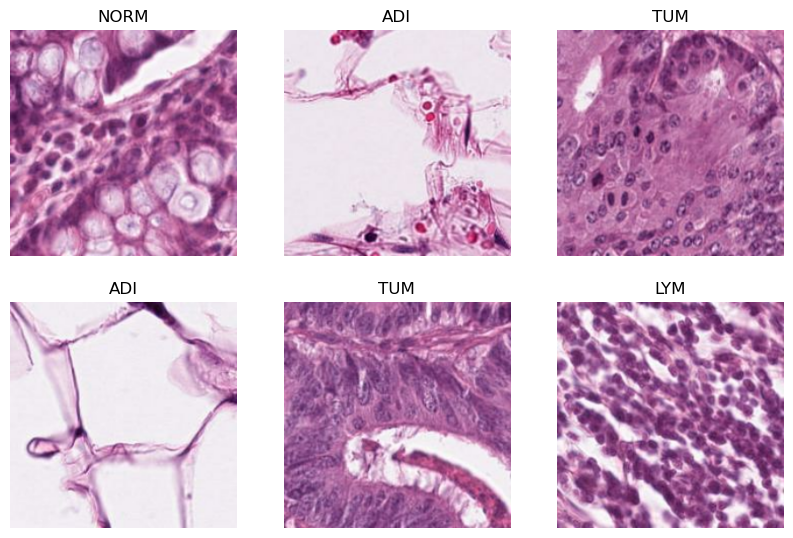

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


# Training The Model


In [9]:
#train the model
resnet_model =  tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
])

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(img_height, img_width,3),
                   pooling='avg',classes=len(class_names),
                   weights='imagenet')


for layer in pretrained_model.layers:
        layer.trainable=False

# Add the pretrained model to our Sequential model
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(len(class_names), activation='softmax'))



In [11]:
# Build the model by running a single forward pass
resnet_model.build((None, img_height, img_width, 3))

In [12]:

# Compile the model
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [13]:
# Display the model summary
resnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,641,417 (94.00 MB)

 Trainable params: 1,053,705 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
# Optimize the dataset pipelines
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Define callbacks
checkpoint_cb = ModelCheckpoint("best_model.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)



In [15]:
# Train the model
epochs = 10

history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 649s 4s/step - accuracy: 0.8175 - loss: 0.5933 - val_accuracy: 0.9443 - val_loss: 0.1675
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 594s 3s/step - accuracy: 0.9560 - loss: 0.1174 - val_accuracy: 0.9624 - val_loss: 0.1224
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.9647 - loss: 0.0977 - val_accuracy: 0.9798 - val_loss: 0.0722
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.9697 - loss: 0.0784 - val_accuracy: 0.9714 - val_loss: 0.0809
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 546s 3s/step - accuracy: 0.9793 - loss: 0.0537 - val_accuracy: 0.9833 - val_loss: 0.0631
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 679s 4s/step - accuracy: 0.9840 - loss: 0.0443 - val_accuracy: 0.9721 - val_loss: 0.0904
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 501s 3s/step - accuracy: 0.9835 - loss: 0.0441 - val_accuracy: 0.9708 - val_loss: 0.0947
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - accuracy: 0.9872 - loss: 0.0317 - val_accu

45/45 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step


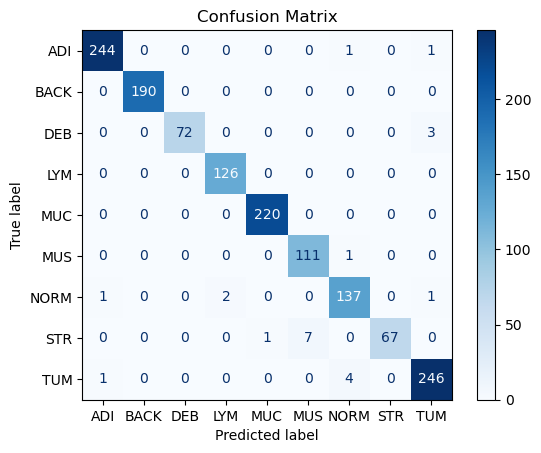

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# Assuming previous code where model is trained and val_ds is the validation dataset

# Predict the labels for the validation set
val_pred = resnet_model.predict(val_ds)
val_pred_labels = np.argmax(val_pred, axis=1)

# Get the true labels
val_true_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Compute the confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()



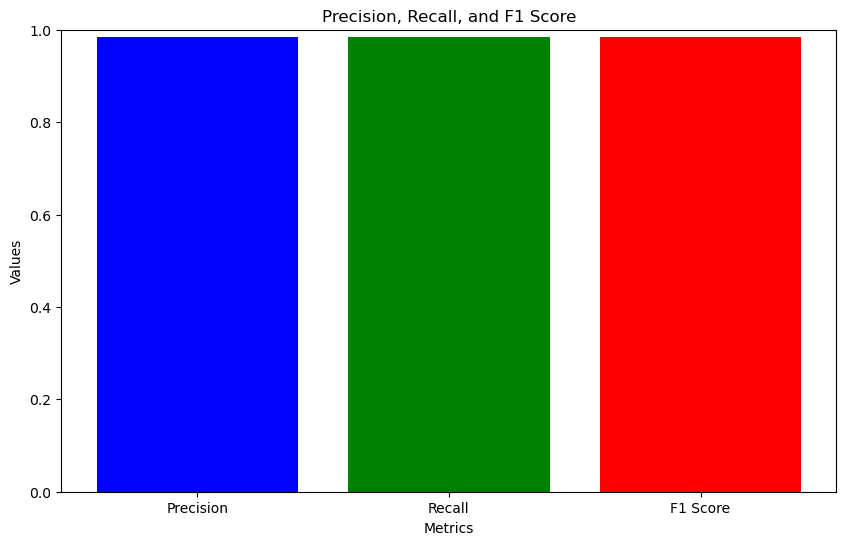

Precision: 0.98
Recall: 0.98
F1 Score: 0.98


In [17]:
#Calculate precision, rec all, and f1 score
precision = precision_score(val_true_labels, val_pred_labels, average='weighted')
recall = recall_score(val_true_labels, val_pred_labels, average='weighted')
f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')

# Create a bar plot for precision, recall, and f1 score
metrics = [precision, recall, f1]
metric_names = ['Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(10, 6))
plt.bar(metric_names, metrics, color=['blue', 'green', 'red'])
plt.title('Precision, Recall, and F1 Score')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.ylim(0, 1)
plt.show()

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


# Evaluating The Model

In [18]:
test_loss, test_accuracy = resnet_model.evaluate(val_ds)

45/45 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9850 - loss: 0.0584


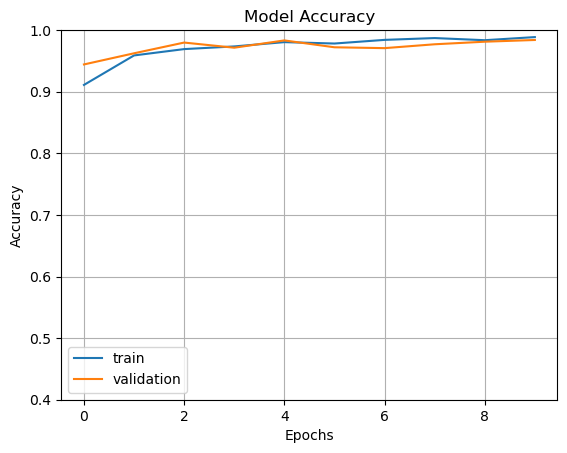

In [19]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

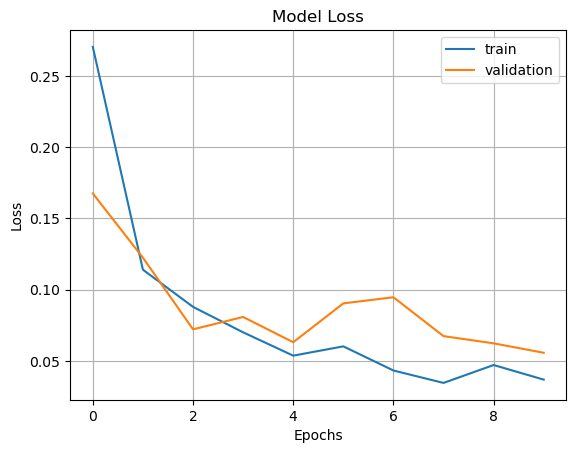

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions

In [21]:
import cv2
# Display an example image from each class
for class_name in class_names:
    img_paths = list(data_dir.glob(f'{class_name}/*.jpg'))
    if img_paths:
        img_path = img_paths[0]
        image = cv2.imread(str(img_path))
        image_resized = cv2.resize(image, (img_height, img_width))
        image = np.expand_dims(image_resized, axis=0)
        print(f"Class: {class_name}, Image shape: {image.shape}")
    else:
        print(f"No images found for class '{class_name}'")


Class: ADI, Image shape: (1, 256, 256, 3)
Class: BACK, Image shape: (1, 256, 256, 3)
Class: DEB, Image shape: (1, 256, 256, 3)
Class: LYM, Image shape: (1, 256, 256, 3)
Class: MUC, Image shape: (1, 256, 256, 3)
Class: MUS, Image shape: (1, 256, 256, 3)
Class: NORM, Image shape: (1, 256, 256, 3)
Class: STR, Image shape: (1, 256, 256, 3)
Class: TUM, Image shape: (1, 256, 256, 3)


In [22]:
pred=resnet_model.predict(image)
print(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[3.15618394e-08 5.09156962e-07 5.45272428e-07 6.71116823e-07
  2.65019821e-06 4.23261054e-06 6.80607118e-05 1.11293785e-01
  8.88629496e-01]]


In [23]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is TUM


In [24]:
resnet_model.save("saved_model.keras")